In [1]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

Solving linear variational problem.


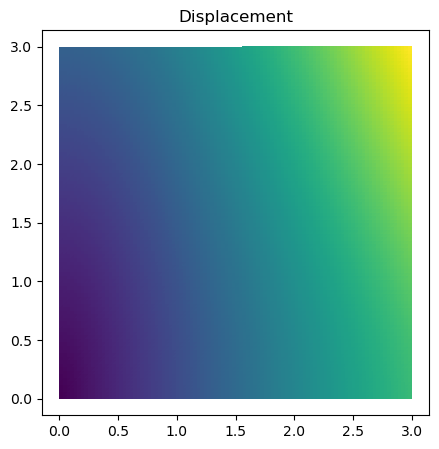

In [ ]:
# /!\ Distances are in mm, forces in N, Young's modulus in N/mm^2
E = 210e3 # 210GPa = 210e3 N/mm^2
nu = 0.3
lambda_ = E*nu/((1+nu)*(1-2*nu))
mu = E/(2*(1+nu))

# Geometry
plate_size = 100 # 3x3mm for Martins et al. 2019, 100x100mm for DIC simulated images
Lmax = Constant(plate_size) # 3mm
n_mesh = 100

# Side loading
m = 0.3 # 10N/mm for Martins et al. 2019, 0.3N/mm for DIC simulated images
b = 50 # 50N

mesh = RectangleMesh(Point(0, 0), Point(Lmax, Lmax), n_mesh, n_mesh)
V = VectorFunctionSpace(mesh, 'P', 1)

tol = 1E-14

def left_boundary(x, on_boundary):
    return on_boundary and near(x[0], 0, tol)

def bottom_boundary(x, on_boundary):
    return on_boundary and near(x[1], 0, tol)

def right_boundary(x, on_boundary):
    return on_boundary and near(x[0], Lmax, tol)

bc1 = DirichletBC(V.sub(0), Constant(0), left_boundary)
bc2 = DirichletBC(V.sub(1), Constant(0), bottom_boundary)
bc = [bc1, bc2]

#mark right boundary
right = AutoSubDomain(right_boundary)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
right.mark(boundaries, 1)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)


# Define strain and stress

def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    # return sym(nabla_grad(u))

def sigma(u):
    return lambda_*div(u)*Identity(d) + 2*mu*epsilon(u)

# Define variational problem
x = SpatialCoordinate(mesh)
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
# f = (0, -x[0]/Lmax)
f = Constant((0, 0))

# T = Constant((pstress, 0))
T = Expression(('m*x[1]+b','0'), degree=1, m=m, b=b)
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds(1)

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution
plt.figure(figsize=(5, 5))
plot(u, title='Displacement', mode='displacement')
plt.axis('equal')

tensor_space = TensorFunctionSpace(mesh, 'P', 1)
strain = project(epsilon(u), tensor_space)
stress = project(sigma(u), tensor_space)

# V = FunctionSpace(mesh, 'P', 1)
# s = sigma(u) - (1./3)*tr(sigma(u))*Identity(d)  # deviatoric stress
# von_Mises = sqrt(3./2*inner(s, s))
# von_Mises = project(von_Mises, V)
# plt.figure(figsize=(5, 5))
# plot(von_Mises, title='Stress intensity')

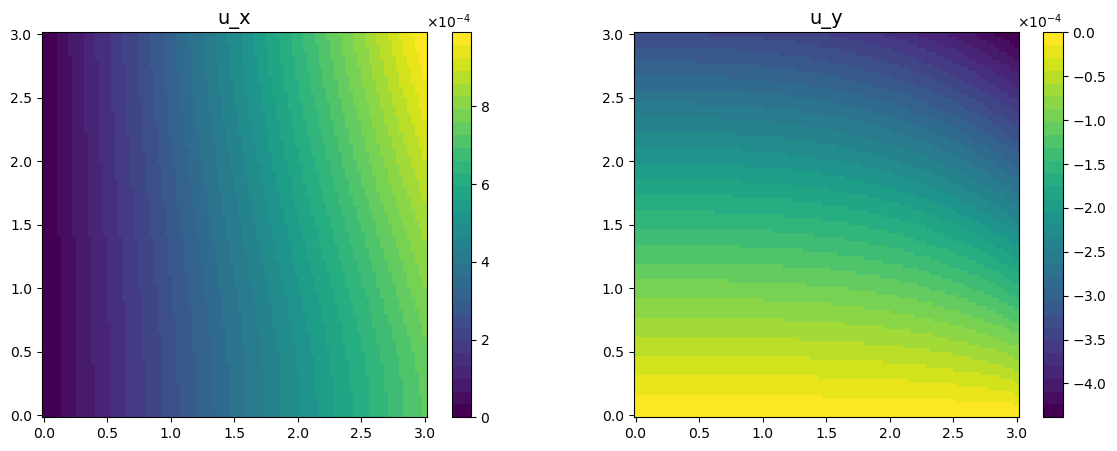

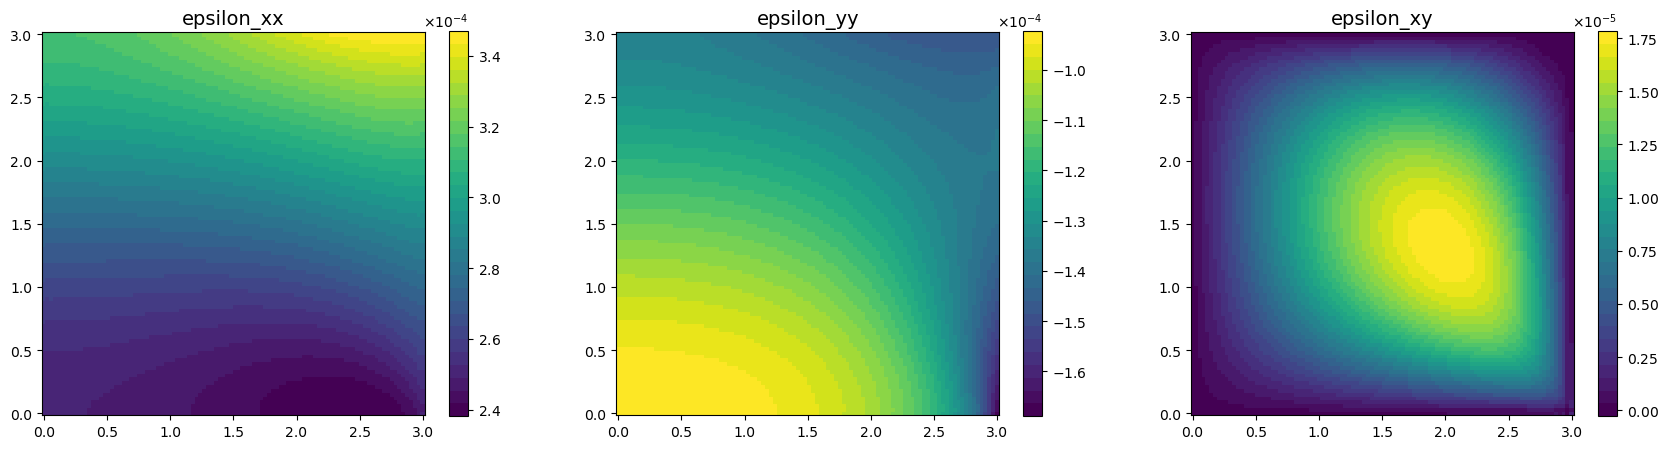

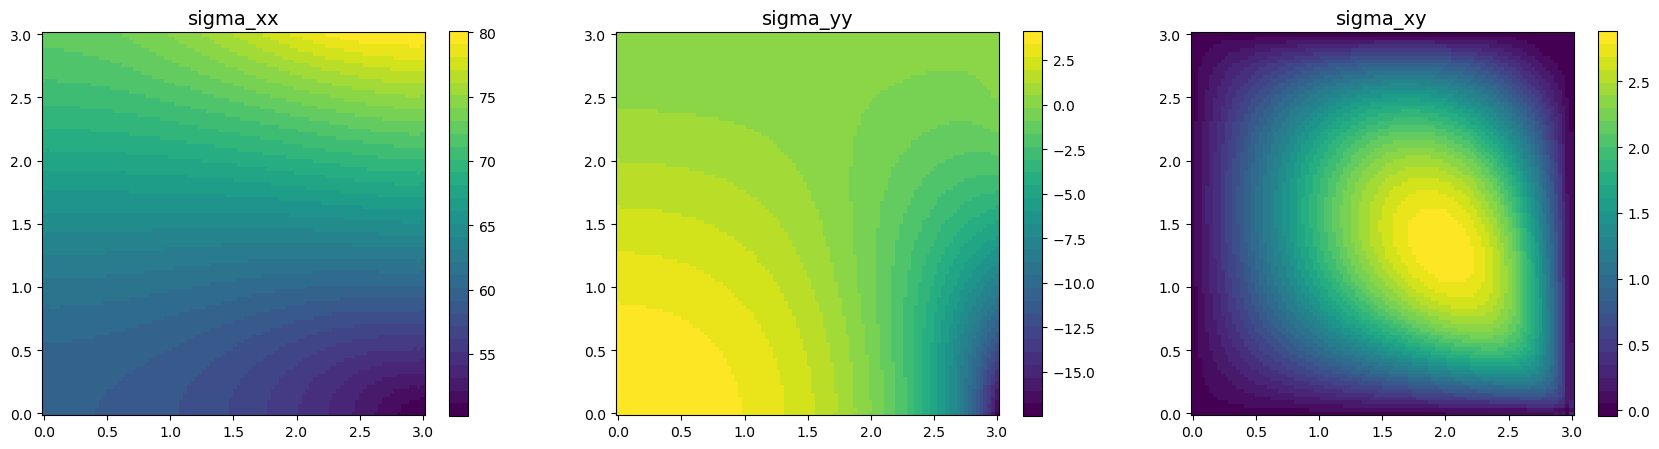

In [89]:
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt


def pcolor_plot(AX, X, Y, C, title,colormap="copper",set_axis = 'on',colorbar=True,**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, 3))
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.set_aspect("equal", "box")
    AX.axis(set_axis)
    AX.set_title(title, fontsize=14)
    fig.colorbar(im, ax=AX, format=formatter)
    return im

cmap = plt.get_cmap('viridis')
num_colors = 30
color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
cmap = ListedColormap(color_values)

n_mesh_points = 100
L_max = 3.0

x_plot = np.linspace(0, L_max, n_mesh_points)
y_plot = np.linspace(0, L_max, n_mesh_points)
X, Y = np.meshgrid(x_plot, y_plot)

X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

u_val = np.array([u(X_grid[i, :]) for i in range(X_grid.shape[0])])
strain_val = np.array([strain(X_grid[i, :]) for i in range(X_grid.shape[0])])
strain_val = np.array([strain_val[:,0], strain_val[:,3], 0.5*(strain_val[:,1]+strain_val[:,2])]).T
stress_val = np.array([stress(X_grid[i, :]) for i in range(X_grid.shape[0])])
stress_val = np.array([stress_val[:,0], stress_val[:,3], 0.5*(stress_val[:,1]+stress_val[:,2])]).T

# # Plot displacement
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
im = pcolor_plot(ax[0], X, Y, u_val[:,0].reshape(X.shape), "u_x",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, u_val[:,1].reshape(X.shape), "u_y",colormap=cmap)

# # Plot strain
fig, ax = plt.subplots(1, 3, figsize=(21, 5))
im = pcolor_plot(ax[0], X, Y, strain_val[:,0].reshape(X.shape), "epsilon_xx",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, strain_val[:,1].reshape(X.shape), "epsilon_yy",colormap=cmap)
im = pcolor_plot(ax[2], X, Y, strain_val[:,2].reshape(X.shape), "epsilon_xy",colormap=cmap)

# Plot stress
fig, ax = plt.subplots(1, 3, figsize=(21, 5))
im = pcolor_plot(ax[0], X, Y, stress_val[:,0].reshape(X.shape), "sigma_xx",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, stress_val[:,1].reshape(X.shape), "sigma_yy",colormap=cmap)
im = pcolor_plot(ax[2], X, Y, stress_val[:,2].reshape(X.shape), "sigma_xy",colormap=cmap)

plt.show()


In [ ]:
# Save solution 
data_dir = "data_fem"
data_name = f"{int(plate_size)}x{int(plate_size)}mm"
data_path = f"{data_dir}/{data_name}"

# Save grid data
np.savetxt(data_path+".dat", np.hstack((X_grid, u_val, strain_val, stress_val)), delimiter=" ")

# Get the deformed coordinates
coordinates = mesh.coordinates()
u_mesh = np.array([u(point) for point in coordinates])
deformed_coordinates = coordinates + u_mesh
deformed_coordinates_updown = coordinates + np.array([u_mesh[::-1,0], u_mesh[::-1,1]]).T

# Save the mesh
with open(data_path+".mesh", "w") as mesh_file:
    # Write node data
    mesh_file.write("*Part, name=Part-1\n*Nodes\n")
    for idx, coord in enumerate(coordinates, start=1):
        mesh_file.write(f"{idx};{coord[0]:.8f};{coord[1]:.8f};0.0\n")
    
    # Write element data
    mesh_file.write("*Elements\n")
    for idx, cell in enumerate(mesh.cells(), start=1):
        element_data = ";".join(str(node + 1) for node in cell)  # Add 1 to make node indices 1-based
        mesh_file.write(f"{idx};{element_data}\n")

#save the node data
with open(data_path+".csv", "w") as node_file:
    node_file.write("*Part, name=Part-1\n*Nodes\n")
    for idx, coord in enumerate(deformed_coordinates, start=1):
        node_file.write(f"{idx};{coord[0]:.8f};{coord[1]:.8f};0.0\n")

In [77]:
from scipy.interpolate import RegularGridInterpolator

# Load solution
data = np.loadtxt(data_path+".dat", delimiter=" ")
X_val = data[:, :2]
u_val = data[:, 2:4]
stress_val = data[:, 7:10]

solution_val = np.hstack((u_val, stress_val))

n_mesh_points = int(np.sqrt(X_val.shape[0]))

# Interpolate solution
x_grid = np.linspace(0, 3, n_mesh_points)
y_grid = np.linspace(0, 3, n_mesh_points)

interpolators = []
for i in range(solution_val.shape[1]):
    interp = RegularGridInterpolator((x_grid, y_grid), solution_val[:, i].reshape(n_mesh_points, n_mesh_points).T)
    interpolators.append(interp)

solution_fn = lambda x, y: np.array([interp((x, y)) for interp in interpolators]).T

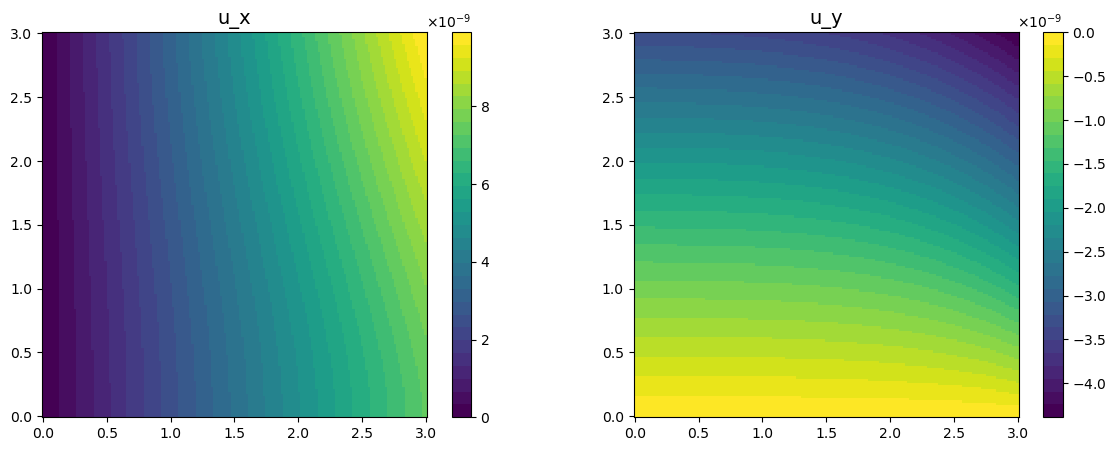

In [78]:
# Check interpolation
n_plot_points = 177
x_plot = np.linspace(0, 3, n_plot_points)
y_plot = np.linspace(0, 3, n_plot_points)
X, Y = np.meshgrid(x_plot, y_plot)
X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

solution_plot = solution_fn(X_grid[:, 0], X_grid[:, 1])

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
im = pcolor_plot(ax[0], X, Y, solution_plot[:,0].reshape(X.shape), "u_x",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, solution_plot[:,1].reshape(X.shape), "u_y",colormap=cmap)

In [5]:
import pandas as pd
import numpy as np
from scipy.interpolate import RegularGridInterpolator

dic_dataset = "200fem_0_noise"

X_dic = pd.read_csv(f"./dic_data/{dic_dataset}/X_trans/pattern_2MP_Numerical_1_0.synthetic.tif_X_trans.csv", delimiter=";").dropna(axis=1).to_numpy() 
Y_dic = pd.read_csv(f"./dic_data/{dic_dataset}/Y_trans/pattern_2MP_Numerical_1_0.synthetic.tif_Y_trans.csv", delimiter=";").dropna(axis=1).to_numpy() 
U_dic = pd.read_csv(f"./dic_data/{dic_dataset}/U_trans/pattern_2MP_Numerical_1_0.synthetic.tif_U_trans.csv", delimiter=";").dropna(axis=1).to_numpy()
V_dic = pd.read_csv(f"./dic_data/{dic_dataset}/V_trans/pattern_2MP_Numerical_1_0.synthetic.tif_V_trans.csv", delimiter=";").dropna(axis=1).to_numpy()
print(f"DIC data loaded, X: {X_dic.shape}, Y: {Y_dic.shape}, U: {U_dic.shape}, V: {V_dic.shape}")

dic_dataset = "200fem_1_5_noise"

X_dic_noise = pd.read_csv(f"./dic_data/{dic_dataset}/X_trans/pattern_2MP_Numerical_9_0.synthetic.tif_X_trans.csv", delimiter=";").dropna(axis=1).to_numpy() 
Y_dic_noise = pd.read_csv(f"./dic_data/{dic_dataset}/Y_trans/pattern_2MP_Numerical_9_0.synthetic.tif_Y_trans.csv", delimiter=";").dropna(axis=1).to_numpy() 
U_dic_noise = pd.read_csv(f"./dic_data/{dic_dataset}/U_trans/pattern_2MP_Numerical_9_0.synthetic.tif_U_trans.csv", delimiter=";").dropna(axis=1).to_numpy()
V_dic_noise = pd.read_csv(f"./dic_data/{dic_dataset}/V_trans/pattern_2MP_Numerical_9_0.synthetic.tif_V_trans.csv", delimiter=";").dropna(axis=1).to_numpy()
print(f"Noisy DIC data loaded, X: {X_dic_noise.shape}, Y: {Y_dic_noise.shape}, U: {U_dic_noise.shape}, V: {V_dic_noise.shape}")

# Noise effect on coordinates
print("Noise effect on :\n X: ", np.linalg.norm(X_dic - X_dic_noise), "\n Y: ", np.linalg.norm(Y_dic - Y_dic_noise), "\n W: ", np.linalg.norm(U_dic - U_dic_noise), "\n V: ", np.linalg.norm(V_dic - V_dic_noise))
print("--> Effect on the coordinates")

U_fem = np.array([u(X_dic.flatten()[i], Y_dic.flatten()[i])[0] for i in range(X_dic.flatten().shape[0])]).reshape(-1, 1)
V_fem = np.array([u(X_dic.flatten()[i], Y_dic.flatten()[i])[1] for i in range(X_dic.flatten().shape[0])]).reshape(-1, 1)


DIC data loaded, X: (48, 50), Y: (48, 50), U: (48, 50), V: (48, 50)
Noisy DIC data loaded, X: (48, 50), Y: (48, 50), U: (48, 50), V: (48, 50)
Noise effect on :
 X:  0.0007347015203724084 
 Y:  0.0005713167211738263 
 W:  0.0007340047333620898 
 V:  0.0004820394864845914
--> Effect on the coordinates


NameError: name 'u' is not defined

/tmp/ipykernel_3604345/2053576034.py:13: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')


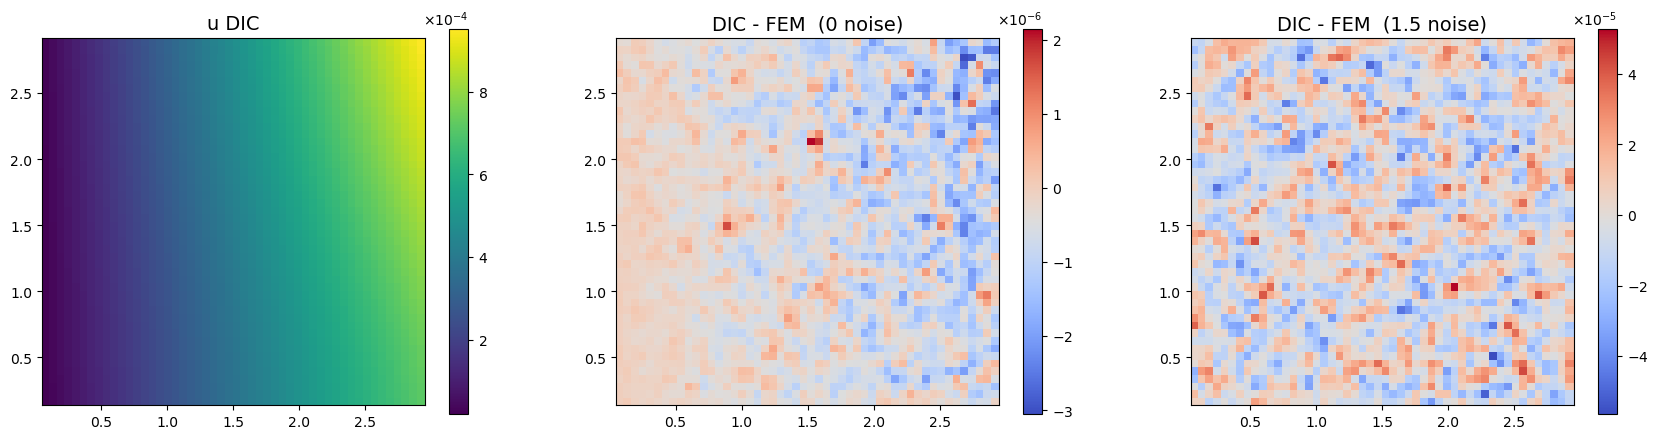

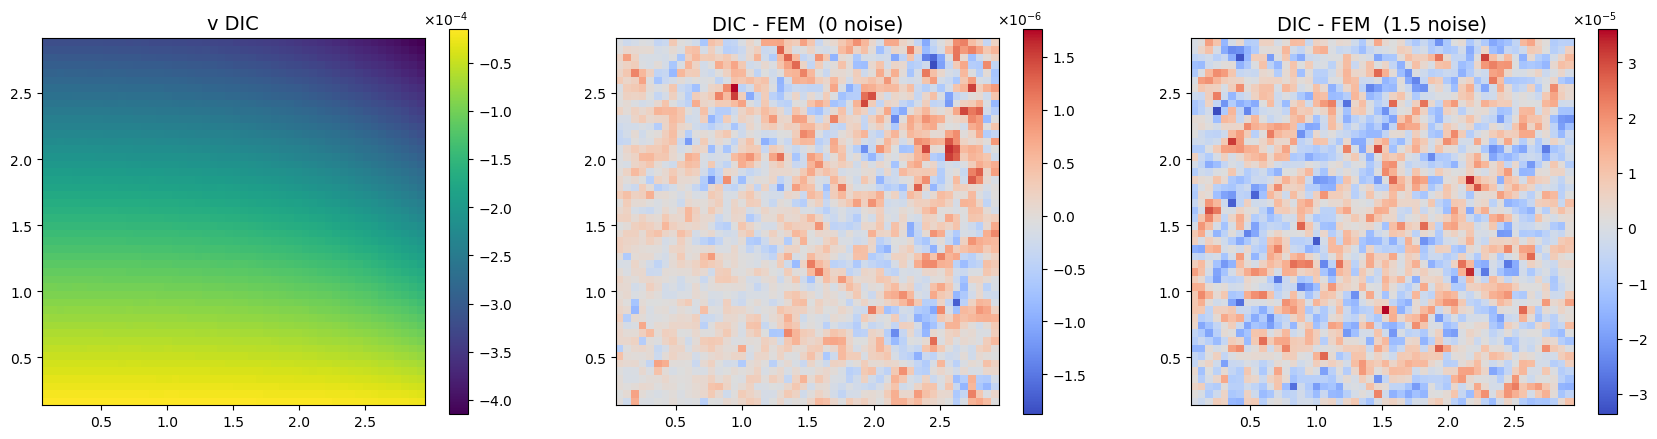

In [109]:

# # Plot DIC displacement
fig, ax = plt.subplots(1, 3, figsize=(21, 5))
im = pcolor_plot(ax[0], X_dic, Y_dic, U_dic, "u DIC",colormap="viridis")#, cmin=0, cmax=0.015)
im = pcolor_plot(ax[1], X_dic, Y_dic, U_dic-U_fem.reshape(X_dic.shape), "DIC - FEM  (0 noise)",colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)
im = pcolor_plot(ax[2], X_dic, Y_dic, U_dic_noise-U_fem.reshape(X_dic.shape), "DIC - FEM  (1.5 noise)",colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)

fig, ax = plt.subplots(1, 3, figsize=(21, 5))
im = pcolor_plot(ax[0], X_dic, Y_dic, V_dic, "v DIC",colormap="viridis")#, cmin=0, cmax=0.015)
im = pcolor_plot(ax[1], X_dic, Y_dic, V_dic-V_fem.reshape(X_dic.shape), "DIC - FEM  (0 noise)",colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)
im = pcolor_plot(ax[2], X_dic, Y_dic, V_dic_noise-V_fem.reshape(X_dic.shape), "DIC - FEM  (1.5 noise)",colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)



---- no noise ----
Coord. sigma: 3.55e-05
Grid step: 5.80e-02
Rel. grid step variation: 3.864%
---- 1.5 noise ----
Coord. sigma: 3.95e-05
Grid step: 5.80e-02
Rel. grid step variation: 3.864%


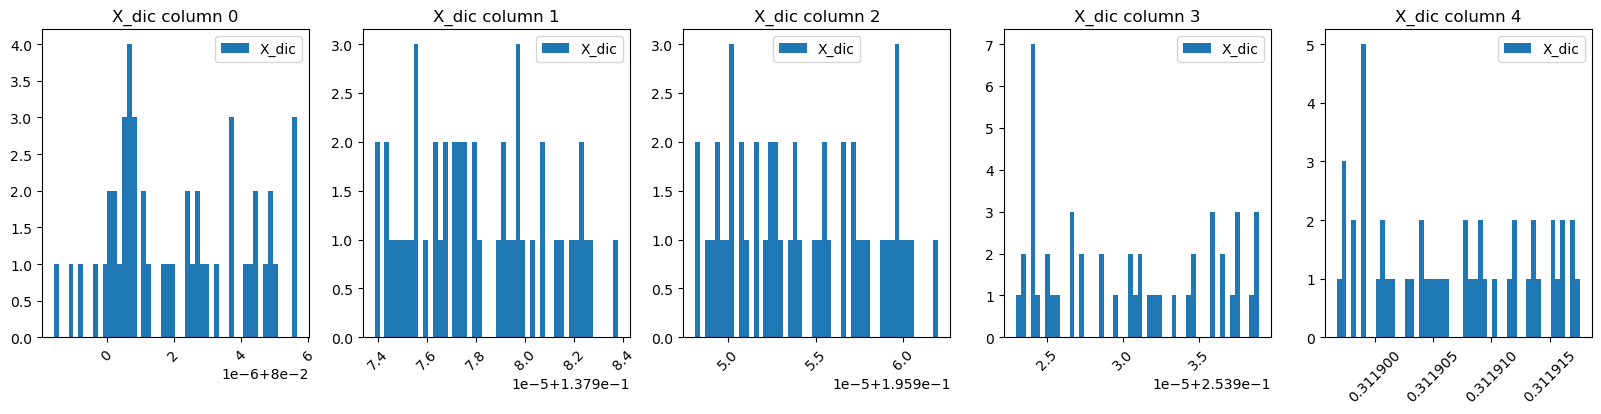

In [111]:
#Histograms of the first 5 X_dic columns
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax[i].hist(X_dic[:,i], bins=50, label='X_dic')
    ax[i].set_title(f"X_dic column {i}")
    ax[i].tick_params(axis='x', rotation=45)
    ax[i].legend()

print("---- no noise ----")
print(f"Coord. sigma: {np.mean(np.std(X_dic, axis=0)):0.2e}")
print(f"Grid step: {np.mean(np.diff(np.mean(X_dic, axis=0))):.2e}")
print(f"Rel. grid step variation: {np.mean(np.diff(np.mean(X_dic, axis=0)))/np.mean(np.mean(X_dic, axis=0))*100:.3f}%")

print("---- 1.5 noise ----")
print(f"Coord. sigma: {np.mean(np.std(X_dic_noise, axis=0)):0.2e}")
print(f"Grid step: {np.mean(np.diff(np.mean(X_dic_noise, axis=0))):.2e}")
print(f"Rel. grid step variation: {np.mean(np.diff(np.mean(X_dic_noise, axis=0)))/np.mean(np.mean(X_dic_noise, axis=0))*100:.3f}%")

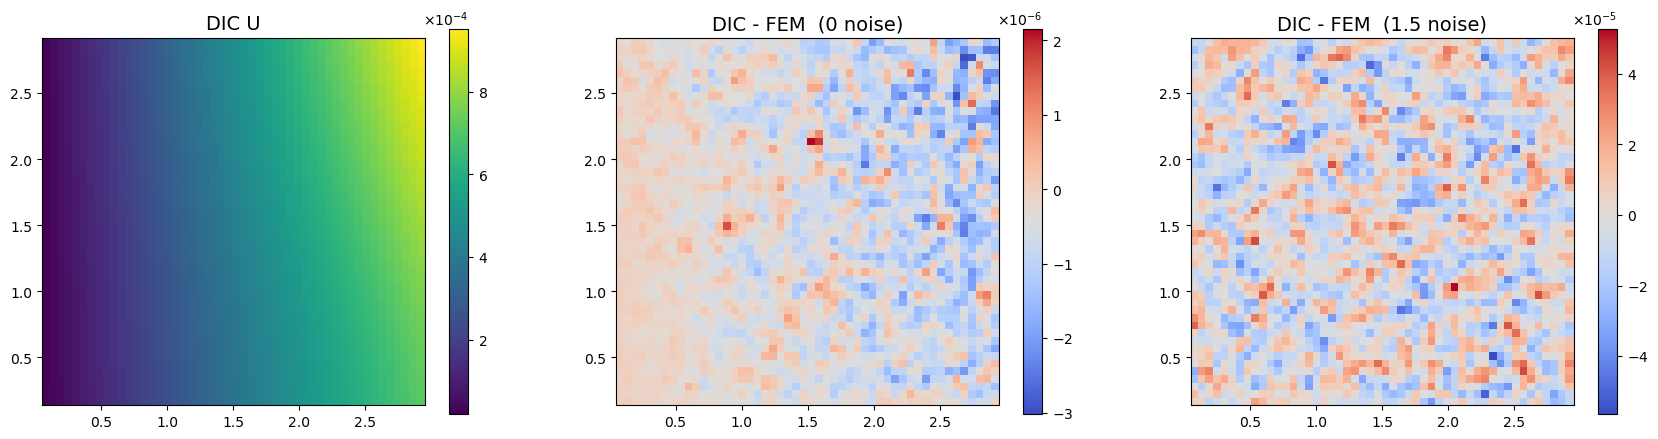

In [118]:
#extracting regular grid from DIC data

x_values = np.mean(X_dic, axis=0)
y_values = np.mean(Y_dic, axis=1)
U_dic_func = RegularGridInterpolator((y_values, x_values), U_dic, method="linear", bounds_error=False, fill_value=None)
U_dic_noise_func = RegularGridInterpolator((y_values, x_values), U_dic_noise, method="linear", bounds_error=False, fill_value=None)

X, Y = np.meshgrid(x_values, y_values)

# Interpolate DIC data to FEM grid
U_dic_interp = U_dic_func((Y.flatten(), X.flatten())).reshape(X.shape)
U_dic_noise_interp = U_dic_noise_func((Y.flatten(), X.flatten())).reshape(X.shape)



# Compute residuals (FEM - DIC)
W_fem = np.array([u([X.flatten()[i], Y.flatten()[i]])[0] for i in range(X.flatten().shape[0])]).reshape(X.shape)

residuals =  U_dic_interp - W_fem
residuals_noise = U_dic_noise_interp - W_fem

# Plot DIC displacement
fig, ax = plt.subplots(1, 3, figsize=(21, 5))

# DIC plot
pcolor_plot(ax[0], X, Y, U_dic_interp, "DIC U", colormap="viridis")#, cmin=0, cmax=0.015)
# Residuals plot
pcolor_plot(ax[1], X, Y, residuals, "DIC - FEM  (0 noise)", colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)

# Residuals plot
pcolor_plot(ax[2], X, Y, residuals_noise, "DIC - FEM  (1.5 noise)", colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)

# plt.tight_layout()
plt.show()


In [4]:
#alignment residual

interp_residuals = U_dic_func((Y_dic.flatten(), X_dic.flatten())).reshape(X_dic.shape) - U_dic

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
im = pcolor_plot(ax, X_dic, Y_dic, interp_residuals, "Grid alignment residual",colormap="coolwarm")
print(f"Alignment residual: {np.linalg.norm(interp_residuals):.2e} is of order 10^-8 wich is below the noise floor")

NameError: name 'U_dic_func' is not defined